### Test case LVV-T85: Verify implementation of Crosstalk Correction Matrix

Verify that the DMS can generate a cross-talk correction matrix from appropriate calibration data.

Verify that the DMS can measure the effectiveness of the cross-talk correction matrix.

**Discussion:** To demonstrate the effectiveness of the cross-talk correction matrix, we will examine a `crosstalk` calibration object from ComCam data. This notebook begins with the crosstalk calibration objects that have already been created during ComCam on-sky data processing. These cross-talk correction matrices were produced by the DMS [cpCrosstalk](https://github.com/lsst/cp_pipe/blob/main/python/lsst/cp/pipe/cpCrosstalk.py) pipeline task (via a [cpCrosstalk.yaml](https://github.com/lsst/cp_pipe/blob/main/pipelines/_ingredients/cpCrosstalk.yaml) pipeline).

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import lsst.afw.display as afwDisplay
from lsst.daf.butler import Butler
from astropy.table import Table

from mpl_toolkits.axes_grid1 import make_axes_locatable

Initialize the butler, and define the collection (corresponding to w_2025_10 processing) we will use.

In [2]:
INSTRUMENT = "LSSTComCam"
COLLECTION = "LSSTComCam/runs/DRP/DP1/w_2025_10/DM-49359"
butler = Butler("/repo/main")

Query the butler for `postISRCCD` images, then select a single dataId and retrieve the image and its associated crosstalk object.

All LSSTComCam detectors have the same crosstalk coefficients, so we only need to perform the test on one.

In [3]:
query = butler.query_datasets('postISRCCD', collections=COLLECTION)

In [4]:
# Select the first image and its crosstalk object:
postisrccd = butler.get(query[1])
crosstalk = butler.get("crosstalk", collections=COLLECTION, dataId=query[1].dataId)

Make a copy of the image so we can test applying the crosstalk correction to it:

In [5]:
postisrccd_copy = postisrccd.clone()

#### Apply the crosstalk correction to the copied image, subtracting off the crosstalk flux.

In [6]:
crosstalk.subtractCrosstalk(postisrccd_copy)

Plot the original image, then the crosstalk-corrected image, side-by-side.

In [7]:
afwDisplay.setDefaultBackend('matplotlib')

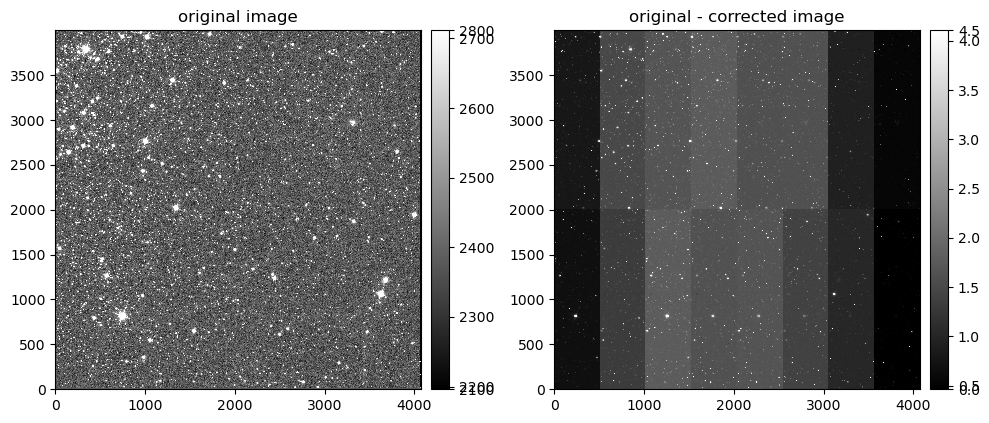

In [8]:
diff = postisrccd.clone()
diff.image -= postisrccd_copy.image

fig, ax = plt.subplots(figsize=(10, 8), nrows=1, ncols=2)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
display0.mtv(postisrccd.image)
plt.title('original image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(diff.image)
plt.title('original - corrected image')

plt.tight_layout()
plt.show()


The residual image (on the right) has lower flux everywhere than the original image (left), confirming that the crosstalk subtraction was successful. Take, as an example, the bright star at (x, y) ~ (800, 900) in the original image. One can see repeated images of that star in the adjacent amplifiers on both the left and right, and indeed in at least 3 amplifiers to the right of it, with decreasing flux further from the detector on which the star originally appears. This is the expected effect of crosstalk (and thus of a crosstalk _correction_.)

Note also that each amplifier has had a different crosstalk coefficient applied, as expected.

#### Examine the crosstalk object's metadata

In [9]:
crosstalk.getMetadata()

OBSTYPE = "CROSSTALK"
CROSSTALK_SCHEMA = "Gen3 Crosstalk"
CROSSTALK_VERSION = 1.2000000000000
INSTRUME = "ComCam"
RAFTNAME = "R22"
SLOTNAME = "S12"
DETECTOR = 5
DET_NAME = "R22_S12"
DET_SER = "ITL-3800C-243"
FILTER = <Unknown>
CALIB_ID = "instrument=LSSTComCam raftName=R22 detectorName=R22_S12 detector=5"
SEQFILE = <Unknown>
SEQNAME = <Unknown>
SEQCKSUM = <Unknown>
CALIBCLS = "lsst.ip.isr.crosstalk.CrosstalkCalib"
DETECTOR_NAME = "R22_S12"
DETECTOR_SERIAL = "ITL-3800C-243"
HAS_CROSSTALK = 1
NAMP = 16
CROSSTALK_SHAPE = [ 16, 16 ]
CROSSTALK_RATIOS_UNITS = "electron"
CALIBDATE = "1970-01-01T00:00:00"


The metadata shows information about the detector and the number of amplifiers, as well as provenance (i.e., software versions, etc.) sufficient to recreate the crosstalk matrices.

Finally, plot an image of the crosstalk coefficients and their associated errors, to demonstrate the magnitude and accuracy of the crosstalk corrections.

Maximum crosstalk error: 6.6199108016620524e-06


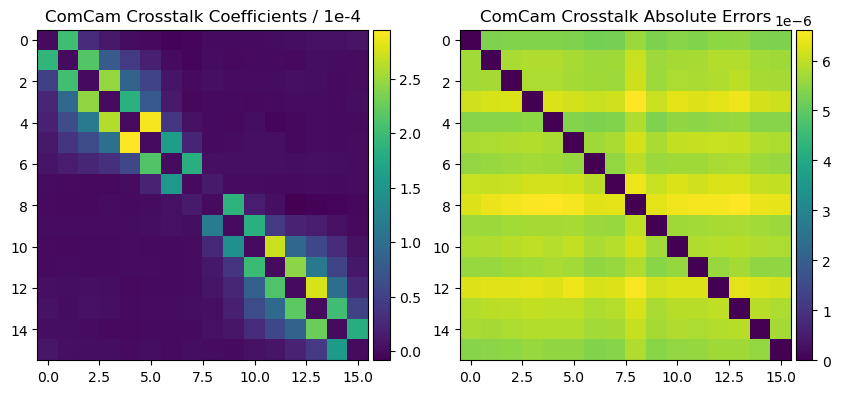

In [10]:
# Plot the errors listed in the calibration as an image.
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(np.array(crosstalk.coeffs)/1e-4)
ax1.set_title("ComCam Crosstalk Coefficients / 1e-4")
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(np.array(crosstalk.coeffErr))
ax2.set_title("ComCam Crosstalk Absolute Errors")
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

fig.show()
print(f"Maximum crosstalk error: {np.max(np.ravel(crosstalk.coeffErr))}")

## Results

We see that the crosstalk coefficients have been measured, and have demonstrated their application to an image. The uncertainties on the coefficients are at a level of less than 1e-5. The effectiveness of the correction has been demonstrated on tests related to the following higher-level Verification Elements:

* [LVV-1624](https://rubinobs.atlassian.net/browse/LVV-1624)
* [LVV-1621](https://rubinobs.atlassian.net/browse/LVV-1621)
* [LVV-1642](https://rubinobs.atlassian.net/browse/LVV-1642)
* [LVV-1633](https://rubinobs.atlassian.net/browse/LVV-1633)
* [LVV-1634](https://rubinobs.atlassian.net/browse/LVV-1634)
* [LVV-9802](https://rubinobs.atlassian.net/browse/LVV-9802)

Given the demonstrated existence and effectiveness of the crosstalk corrections, we deem this test's result a *Pass*.